In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import inspect
from matplotlib import pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
from amuse.units import units

sns.set(font_scale=1.5, rc={'text.usetex' : True})
sns.set_style("ticks")

In [69]:
def semi_ecc(p, v, m):
    r = (p*p).sum(axis=1)**0.5
    vm2 = (v*v).sum(axis=1)
    E =  vm2 * 0.5 - m / r
    
    h = np.cross(p, v, axis=1)
    evecc = np.cross(v, h, axis=1) / m.reshape((-1,1)) - p / r.reshape((-1,1))
    e = (evecc*evecc).sum(axis=1)**0.5
    a = - m / (2*E)
    
    return a, e
    
def reduce_data(data, Ntrunc):
    MSun = (1 | units.MSun).value_in(units.g)
    au = (1 | units.au).value_in(units.cm)
    yr2pi = (1 | (units.yr / (2*np.pi) )).value_in(units.s)
    day = (1 | units.day).value_in(units.s)

    mass = np.array([data["mass1"], data["mass2"]]) / MSun
    vel = np.array([[data["vx1"], data["vy1"], data["vz1"]], 
                    [data["vx2"], data["vy2"], data["vz2"]]]) * yr2pi / au
    pos = np.array([[data["x1"], data["y1"], data["z1"]], 
                    [data["x2"], data["y2"], data["z2"]]]) / au
    time = data["time"].to_numpy() / day
    
    return time[:Ntrunc], mass.T[:Ntrunc], pos.transpose(2,0,1)[:Ntrunc], vel.transpose(2,0,1)[:Ntrunc]

In [70]:
# Hila Glanz data
datafold = "../data/gdata/"
csvfs = [x for x in os.listdir(datafold) if x.endswith(".csv")]
csvfs.sort()
print(csvfs)
dictecc = {0: 0.2, 1 : 0.5, 2 : 0.7, 3 : 0.0}
N_trunc = [7647, 14412, 73200 , -1]

['02resultCSV.csv', '05resultCSV.csv', '07resultCSV.csv', '0resultCSV.csv']


In [133]:
isim = 2
data = pd.read_csv(datafold+csvfs[isim])
print(data.columns)
data.head(1)

Index(['mass1', 'radius1', 'vx1', 'vy1', 'vz1', 'x1', 'y1', 'z1', 'ax1', 'ay1',
       'az1', 'mass2', 'radius2', 'vx2', 'vy2', 'vz2', 'x2', 'y2', 'z2', 'ax2',
       'ay2', 'az2', 'time'],
      dtype='object')


,mass1,radius1,vx1,vy1,vz1,x1,y1,z1,ax1,ay1,...,vx2,vy2,vz2,x2,y2,z2,ax2,ay2,az2,time
0,2.043933e+33,1.250608e+11,602758.537267,2289.72414,-2816.839439,-1.351533e+09,-8.862714e+12,-3.199994e+10,0.391243,0.552379,...,-2.404547e+06,-2260.58296,-0.200293,-4.153871e+09,3.526520e+13,-346.008354,0.000059,-0.545349,-0.000048,0.0


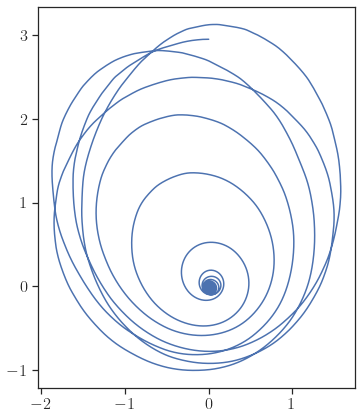

In [134]:
time, mass, pos, vel = reduce_data(data, Ntrunc=N_trunc[isim])
mtot = mass.sum(axis=1) 
dpos = pos[:,1] - pos[:,0]
dvel = vel[:,1] - vel[:,0] 
f, ax = plt.subplots(1,1, figsize=(7,7))
ax.set_aspect("equal")

ax.plot(dpos[:,0], dpos[:,1])

In [135]:
from scipy.signal import argrelextrema

semi, ecc = semi_ecc(dpos, dvel, mtot)
sep = (dpos*dpos).sum(axis=1)**0.5

peris = argrelextrema(sep, np.less, order=10)[0]
apos  = argrelextrema(sep, np.greater, order=10)[0]

rp = sep[peris]
ra = sep[apos]

print(len(rp), len(ra))

68 60


In [136]:
it = 0
iaex = ipex = 0
e_l, t_l = [], []
while True:
    if iaex == len(apos) or ipex == len(peris): break
    
    # Apo to peri
    while True:
        idx_apo = apos[iaex]
        idx_peri = peris[ipex]

        tapo = time[idx_apo]
        tperi = time[idx_peri]

        if tperi > tapo:
            e = (sep[idx_apo] - sep[idx_peri]) / (sep[idx_apo] + sep[idx_peri])
            t = (time[idx_apo] + time[idx_peri])/2
            e_l.append(e)
            t_l.append(t)
            break
        else:
            ipex+=1
            continue
    
    while True:
        idx_apo_next = apos[iaex+1]
        tapo_next = time[idx_apo_next]

        if tperi < tapo_next:
            e = (sep[idx_apo_next] - sep[idx_peri]) / (sep[idx_apo_next] + sep[idx_peri])
            t = (time[idx_apo_next] + time[idx_peri])/2
            e_l.append(e)
            t_l.append(t)
            break
        else:
            iaex+=1
            continue

    ipex+=1
    iaex+=1
#print(e_l, t_l)

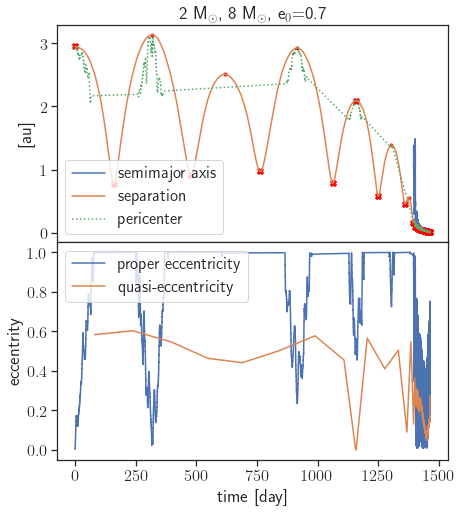

In [137]:
f, ax = plt.subplots(2, 1, figsize=(7,8), sharex=True)

f.subplots_adjust(hspace=0)

afilt = (semi>0) & (semi < 1.5)
apofilt = (semi>0) & (semi < 10)
ax[0].plot(time[afilt], semi[afilt], label="semimajor axis")
ax[0].set_title("2 M$_\odot$, 8 M$_\odot$, e$_0$={:g}".format(dictecc[isim]))
ax[0].plot(time, sep, label="separation")
ax[0].plot(time[apofilt], semi[apofilt]*(1-ecc[apofilt]), label="pericenter", ls=":")
ax[0].scatter(time[peris], sep[peris], c="red", marker="X")
ax[0].scatter(time[apos], sep[apos], c="red", marker=".")
ax[0].set_ylabel("[au]")
ax[0].legend()

ax[1].plot(time[semi>0], ecc[semi>0], label="proper eccentricity")
ax[1].plot(t_l, e_l, label="quasi-eccentricity")
ax[1].set_xlabel("time [day]")
ax[1].set_ylabel("eccentrity")
ax[1].legend(loc="upper left")


plt.savefig("8R2G-{:g}.png".format(dictecc[isim]))
plt.show()